### Regression Analysis and Predictive Modeling with Crime Data

This problem set explores the application of regression techniques to analyze crime data. The project involves integrating multiple datasets, including census and household data, to examine the relationship between various demographic and socioeconomic predictors and crime rates. Techniques such as simple and multiple linear regression are applied to identify significant predictors and assess the model's accuracy. Residual analysis and critical evaluation of the results ensure the robustness of the model. This project showcases data integration, regression modeling, and statistical interpretation skills, relevant for data-driven decision-making.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

### Regression Analysis with Crime and Census Data

In this problem set, I will perform regression analysis on a dataset that combines police beat data with census tract information. The objective is to examine relationships between demographic factors and crime rates across different geographical areas. By leveraging data from the years 2016 to 2018, this project focuses on identifying significant predictors of crime rates and evaluating model performance through regression techniques.

This analysis demonstrates key skills in data integration, regression modeling, and statistical evaluation, highlighting my ability to work with real-world datasets to derive meaningful insights.

In [4]:
data = pd.read_csv('census_beat_data_trimmed.csv')

#### (b) Examine years in data

Next, examine the years that are present in the dataset. Does it look as though there are years with incomplete or missing data? Filter the data such that it only contains data from the years 2016-2018 (inclusive).

In [6]:
unique_years = data['year'].unique()
print("Unique years in the dataset:", unique_years)

# Count the number of records for each year to identify any incomplete years
year_counts = data['year'].value_counts().sort_index()
print("\nNumber of records per year:")
print(year_counts)


threshold = 0.8 * max(year_counts)
incomplete_years = year_counts[year_counts < threshold].index.tolist()
print("\nYears with potentially incomplete data:", incomplete_years)

#: Filter the data to only include the years 2016-2018
filtered_data = data[(data['year'] >= 2016) & (data['year'] <= 2018)]
print("\nFiltered data sample (2016-2018):")
print(filtered_data.head())

Unique years in the dataset: [2012 2013 2014 2015 2016 2017 2018 2019]

Number of records per year:
year
2012    40768
2013    45259
2014    49101
2015    47491
2016    48957
2017    49959
2018    50922
2019    15523
Name: count, dtype: int64

Years with potentially incomplete data: [2019]

Filtered data sample (2016-2018):
                      geo_id pri_offense_desc  year  pop_18_24  pop_25_over  \
181960  1400000US53033011401        THEFT-OTH  2016        606         3640   
181961  1400000US53033001100   THEFT-SHOPLIFT  2016        150         2089   
181962  1400000US53033009000   THEFT-CARPROWL  2016        313         2993   
181963  1400000US53033005402   THEFT-SHOPLIFT  2016        454         2601   
181964  1400000US53033006702   THEFT-BUILDING  2016        144         2690   

        ed_high_sch_grad_higher_25_over  ed_bach_deg_grad_higher_25_over  
181960                             3315                             1299  
181961                             2002          

In [7]:
''' It seems that 2019 has an incomplete year because it has less then 80 percent than the complete years'''

' It seems that 2019 has an incomplete year because it has less then 80 percent than the complete years'

### Filter and Create Variables: Examining Crime Types

In this step, I will limit the dataset to include only crimes of interest. The **pri_offense_desc** variable provides a description of the primary offense, which includes both broad and specific categorizations (separated by hyphens). 

The objective is to:
- Identify the five most common types of crime based on the broadest categorization (i.e., by examining the categories before the first hyphen).

This will help focus the analysis on the most frequent crime types for further exploration and regression modeling.

In [10]:

# Extract the broadest categorization of the crime by splitting the pri_offense_desc at the first hyphen
data['broad_category'] = data['pri_offense_desc'].apply(lambda x: x.split('-')[0])

# Count the occurrences of each broad category
broad_category_counts = data['broad_category'].value_counts()

# Identify the five most common broad categories
top_five_broad_categories = broad_category_counts.head(5)

(top_five_broad_categories, broad_category_counts)

(broad_category
 THEFT       189238
 BURGLARY     54111
 VEH          29709
 ASSLT        15821
 TRESPASS     14362
 Name: count, dtype: int64,
 broad_category
 THEFT                       189238
 BURGLARY                     54111
 VEH                          29709
 ASSLT                        15821
 TRESPASS                     14362
 ROBBERY                      11376
 NARC                          8698
 DUI                           8054
 SEXOFF                        4315
 CHILD                         3742
 WEAPON                        3098
 RAPE                           985
 PROSTITUTION PATRONIZING       925
 PROSTITUTION                   862
 ARSON                          656
 LIQUOR LAW VIOLATION           637
 ADULT                          507
 HOMICIDE                       175
 DISORDERLY CONDUCT             163
 ENDANGERMENT                   128
 PORNOGRAPHY                    122
 PROSTITUTION LOITERING         117
 SEX ABUSE MINOR                 66
 INTERFERE W

In [11]:
''' The top 5 is THEFT, BURGLARY, VEH, ASSLT, TRESPASS '''

' The top 5 is THEFT, BURGLARY, VEH, ASSLT, TRESPASS '

#### Filter by crime type

Filter the data so that it only contains the top-3 most frequent of the (broadest) crime categorizations.

In [13]:
top_three_categories = top_five_broad_categories.index[:3]
filtered_top_three_data = data[data['broad_category'].isin(top_three_categories)]

# Get the dimensions of the filtered dataset
filtered_dimensions = filtered_top_three_data.shape

filtered_dimensions

(273058, 8)

In [14]:
''' (273058, 8) ''' 

' (273058, 8) '

### Aggregating Data at the Census Tract Level

The current unit of observation is individual crimes, but for this analysis, we need to aggregate the data at the **census tract level**. This will allow us to analyze trends and relationships at a broader, geographic level. 

The goal is to create a new DataFrame called **data_agg** with the following columns:
- **geo_id**: The census tract identifier (used for aggregation).
- **year**: Aggregated by year to track changes over time.
- **pop_18_24**: Population aged 18-24, duplicated for each geo_id/year combination.
- **pop_25_over**: Population aged 25 and over, duplicated for each geo_id/year combination.
- **ed_high_sch_grad_higher_25_over**: Number of people 25 and over with a high school degree or higher, duplicated for each geo_id/year combination.
- **ed_bach_deg_grad_higher_25_over**: Number of people 25 and over with a bachelor’s degree or higher, duplicated for each geo_id/year combination.
- **num_crimes**: The number of crimes per geo_id/year combination (this will be a count of crimes for each tract/year).

This aggregation will provide a structured dataset for further analysis, allowing us to explore the relationship between demographic factors and crime at the census tract level.

In [16]:
data_agg = filtered_top_three_data.groupby(['geo_id', 'year']).agg(
    pop_18_24=('pop_18_24', 'first'),
    pop_25_over=('pop_25_over', 'first'),
    ed_high_sch_grad_higher_25_over=('ed_high_sch_grad_higher_25_over', 'first'),
    ed_bach_deg_grad_higher_25_over=('ed_bach_deg_grad_higher_25_over', 'first'),
    num_crimes=('broad_category', 'size')
).reset_index()

In [17]:
data_agg.head()

,geo_id,year,pop_18_24,pop_25_over,ed_high_sch_grad_higher_25_over,ed_bach_deg_grad_higher_25_over,num_crimes
0,1400000US53033000202,2012,228,3194,2938,1910,567
1,1400000US53033000202,2013,228,3194,2938,1910,723
2,1400000US53033000202,2014,228,3194,2938,1910,709
3,1400000US53033000202,2015,228,3194,2938,1910,575
4,1400000US53033000202,2016,228,3194,2938,1910,584


### Creating Normalized Education Variables

The variables **ed_high_sch_grad_higher_25_over** and **ed_bach_deg_grad_higher_25_over** represent counts of individuals with high school and bachelor’s degrees, respectively, for the population aged 25 and over. To make these variables more comparable across different census tracts, I will create normalized versions of these variables:

- **high_sch_grad_prop**: Proportion of individuals with a high school degree or higher, normalized by the population aged 25 and over.
- **coll_grad_prop**: Proportion of individuals with a bachelor’s degree or higher, normalized by the population aged 25 and over.

These normalized variables will provide insight into the educational attainment of each tract, accounting for differences in population size.

In [19]:
# Calculate the proportion of high school graduates or higher
data_agg['high_sch_grad_prop'] = data_agg['ed_high_sch_grad_higher_25_over'] / data_agg['pop_25_over']

# Calculate the proportion of college graduates or higher
data_agg['coll_grad_prop'] = data_agg['ed_bach_deg_grad_higher_25_over'] / data_agg['pop_25_over']

data_agg.head()

,geo_id,year,pop_18_24,pop_25_over,ed_high_sch_grad_higher_25_over,ed_bach_deg_grad_higher_25_over,num_crimes,high_sch_grad_prop,coll_grad_prop
0,1400000US53033000202,2012,228,3194,2938,1910,567,0.91985,0.597996
1,1400000US53033000202,2013,228,3194,2938,1910,723,0.91985,0.597996
2,1400000US53033000202,2014,228,3194,2938,1910,709,0.91985,0.597996
3,1400000US53033000202,2015,228,3194,2938,1910,575,0.91985,0.597996
4,1400000US53033000202,2016,228,3194,2938,1910,584,0.91985,0.597996


### Integrating Household Data: Load and Examine

In this step, I will load the **household_data.csv** file, which contains information on:
- The number of households.
- The number of households with children.

Once the data is loaded, I will examine the distributions of these variables (excluding **geo_id**) to better understand the household composition within the census tracts of interest. This will help in identifying trends and patterns related to household demographics for further integration into the analysis.

In [21]:
household_data = pd.read_csv('household_data.csv')
household_data.head()

,geo_id,num_hholds,num_hholds_with_child
0,1400000US53033000202,1651,450
1,1400000US53033000602,1682,381
2,1400000US53033001100,1086,267
3,1400000US53033001201,1968,284
4,1400000US53033001400,2329,565


In [22]:
household_data_description = household_data.drop(columns='geo_id').describe()
print(household_data_description)

        num_hholds  num_hholds_with_child
count    50.000000               50.00000
mean   1977.820000              345.78000
std     585.198054              215.01175
min      86.000000                6.00000
25%    1674.500000              132.50000
50%    1945.500000              378.00000
75%    2308.500000              528.25000
max    3164.000000              831.00000


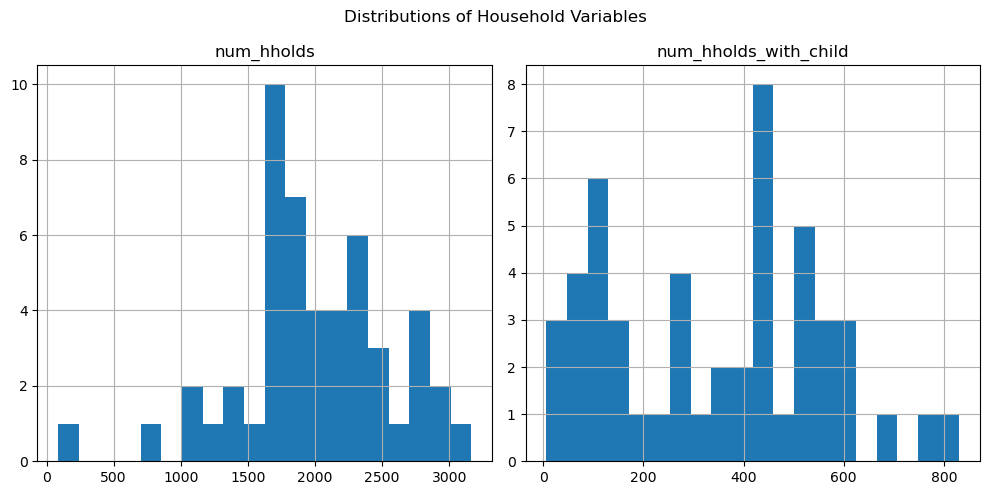

In [23]:
household_data.drop(columns='geo_id').hist(bins=20, figsize=(10, 5))
plt.suptitle('Distributions of Household Variables')
plt.tight_layout()
plt.show()

### Joining Datasets: Census and Household Data

In this step, I will join the **data_agg** DataFrame with the household data using the **geo_id** column as the key. Since the household data doesn't vary by year, I will duplicate the household data for each **geo_id** across the years in **data_agg**.

The resulting dataset will be named **data_reg**, and I will examine its dimensions after the join to ensure that the merge was successful.

This combined dataset will allow for a more comprehensive analysis by incorporating both demographic and household information.

In [25]:
data_reg = pd.merge(data_agg, household_data, on='geo_id', how='left')
data_reg.head()

,geo_id,year,pop_18_24,pop_25_over,ed_high_sch_grad_higher_25_over,ed_bach_deg_grad_higher_25_over,num_crimes,high_sch_grad_prop,coll_grad_prop,num_hholds,num_hholds_with_child
0,1400000US53033000202,2012,228,3194,2938,1910,567,0.91985,0.597996,1651,450
1,1400000US53033000202,2013,228,3194,2938,1910,723,0.91985,0.597996,1651,450
2,1400000US53033000202,2014,228,3194,2938,1910,709,0.91985,0.597996,1651,450
3,1400000US53033000202,2015,228,3194,2938,1910,575,0.91985,0.597996,1651,450
4,1400000US53033000202,2016,228,3194,2938,1910,584,0.91985,0.597996,1651,450


In [26]:
print(data_reg.shape)

(400, 11)


### Simple Linear Regression

Using the **data_reg** dataset, I will fit simple linear regression models to predict the number of crimes in a tract using the following explanatory variables:

- **year**
- **pop_18_24**
- **pop_25_over**
- **ed_high_sch_grad_higher_25_over**
- **ed_bach_deg_grad_higher_25_over**
- **high_sch_grad_prop**
- **coll_grad_prop**
- **num_hholds** (number of households)
- **num_hholds_with_child** (number of households with children)

The goal is to determine in which of the models there is a statistically significant association between the predictor and the response (number of crimes).

**HINT**: Iterating through the variables using a for loop and storing the results from each model will allow for easy comparison of the significance of each predictor.

In [28]:
# List of explanatory variables
explanatory_vars = [
    'year',
    'pop_18_24',
    'pop_25_over',
    'ed_high_sch_grad_higher_25_over',
    'ed_bach_deg_grad_higher_25_over',
    'high_sch_grad_prop',
    'coll_grad_prop',
    'num_hholds',
    'num_hholds_with_child'
]


model_results = {}

In [29]:
for var in explanatory_vars:
    X = data_reg[[var]]  # Predictor
    X = sm.add_constant(X)  # Add a constant 
    y = data_reg['num_crimes']  # Response variable
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Store the summary of the model
    model_results[var] = {
        'coef': model.params[var],
        'p-value': model.pvalues[var],
        'R-squared': model.rsquared
    }

In [30]:
# Display results
for var, result in model_results.items():
    print(f"Variable: {var}")
    print(f"  Coefficient: {result['coef']:.4f}")
    print(f"  p-value: {result['p-value']:.4f}")
    print(f"  R-squared: {result['R-squared']:.4f}")
    print("-" * 40)

Variable: year
  Coefficient: -34.3705
  p-value: 0.0000
  R-squared: 0.0672
----------------------------------------
Variable: pop_18_24
  Coefficient: 0.0137
  p-value: 0.5916
  R-squared: 0.0007
----------------------------------------
Variable: pop_25_over
  Coefficient: -0.0286
  p-value: 0.0451
  R-squared: 0.0100
----------------------------------------
Variable: ed_high_sch_grad_higher_25_over
  Coefficient: -0.0128
  p-value: 0.3790
  R-squared: 0.0019
----------------------------------------
Variable: ed_bach_deg_grad_higher_25_over
  Coefficient: 0.0216
  p-value: 0.2058
  R-squared: 0.0040
----------------------------------------
Variable: high_sch_grad_prop
  Coefficient: 1121.2421
  p-value: 0.0000
  R-squared: 0.0574
----------------------------------------
Variable: coll_grad_prop
  Coefficient: 479.6957
  p-value: 0.0000
  R-squared: 0.0648
----------------------------------------
Variable: num_hholds
  Coefficient: 0.0007
  p-value: 0.9777
  R-squared: 0.0000
--------

In [31]:
# Determine significant variables
significance_threshold = 0.05
significant_vars = [var for var, result in model_results.items() if result['p-value'] < significance_threshold]

print("Significant variables at 0.05 significance level:", significant_vars)

Significant variables at 0.05 significance level: ['year', 'pop_25_over', 'high_sch_grad_prop', 'coll_grad_prop', 'num_hholds_with_child']


#### (b) Multiple regression

Fit a multiple regression model to predict the response using all of the predictors from the previous section. Describe your results. For which predictors can we reject the null hypothesis $H_0: \beta_j = 0$? Are these the same from the previous section? Explain what may be going on.

In [33]:
# Define the response variable and predictors
y = data_reg['num_crimes']
X = data_reg[[
    'year',
    'pop_18_24',
    'pop_25_over',
    'ed_high_sch_grad_higher_25_over',
    'ed_bach_deg_grad_higher_25_over',
    'high_sch_grad_prop',
    'coll_grad_prop',
    'num_hholds',
    'num_hholds_with_child'
]]

# Add a constant to the model 
X = sm.add_constant(X)

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             num_crimes   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     10.87
Date:                Thu, 17 Oct 2024   Prob (F-statistic):           3.94e-15
Time:                        16:16:11   Log-Likelihood:                -2809.3
No. Observations:                 400   AIC:                             5639.
Df Residuals:                     390   BIC:                             5679.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [34]:
p_values = model.pvalues
significance_level = 0.05
significant_predictors = p_values[p_values < significance_level].index.tolist()

print("\nSignificant predictors at 0.05 significance level:", significant_predictors)


Significant predictors at 0.05 significance level: ['const', 'year', 'pop_25_over', 'ed_high_sch_grad_higher_25_over', 'ed_bach_deg_grad_higher_25_over', 'high_sch_grad_prop', 'coll_grad_prop', 'num_hholds_with_child']


In [35]:
''' It seems tht the only two predictors that cant reject the null hypothesis are (num_hholds), and (pop_25_over)''' 

' It seems tht the only two predictors that cant reject the null hypothesis are (num_hholds), and (pop_25_over)'

### Interpreting Relationships in the Multivariate Regression

For each of the variables in the multivariate regression model, I will interpret the relationship between the explanatory variables and the response variable (number of crimes) based on the calculated coefficients.

**Significant Predictors**:
- Some predictors may lose significance if their effect is explained by other correlated predictors. For example, **pop_25_over** and **ed_high_sch_grad_higher_25_over** might be highly correlated, affecting their significance in the model.

**Possible Explanations**:
- **Multicollinearity**: If predictors are highly correlated, multicollinearity can inflate the standard errors of the coefficients, making it harder to detect significant predictors. This could result in a variable being significant in a simple regression but not in a multivariate model.
- **Suppressor Effects**: In some cases, a variable that seems insignificant in isolation can become significant when included in a model with other predictors. This happens when the variable reveals unique variance that was previously covered by another predictor.

### Considering the Downsides of Data Duplication

Though the crime incident data is available for each individual year, the census and household data were duplicated for each tract across all years. This assumes that the demographic and household characteristics remain constant over time. However, there are several potential downsides to this approach:

- **Changing Population Characteristics**: Census and household data can change significantly over time due to factors such as population shifts, economic changes, urban development, or policy shifts.
- **Outdated or Misleading Insights**: Assuming these characteristics are constant across years can lead to outdated or inaccurate conclusions. Population changes in terms of age distribution, education levels, or household composition can have a significant impact on the analysis.
- **Introduction of Bias**: Using static data in a dynamic environment may introduce bias into the regression model, as the predictors no longer accurately reflect the conditions at each point in time.

Acknowledging these limitations is important for interpreting the results of the analysis.

### Examining Residuals

To assess the performance of the multiple regression model, I will plot the residuals with the following variables on the x-axis:

- **year**
- **ed_high_sch_grad_higher_25_over**
- **coll_grad_prop**

The goal is to analyze the patterns in the residuals to identify any potential issues, such as non-linearity, heteroscedasticity, or outliers. 

**Comments**:
- **Residuals vs. Year**: Look for any trends over time that could indicate changes in model accuracy or unaccounted variability in the data.
- **Residuals vs. ed_high_sch_grad_higher_25_over**: Assess whether the educational variable is properly accounted for in the model, and check for any systematic patterns in the residuals.
- **Residuals vs. coll_grad_prop**: Similar to above, examine whether higher education levels are well represented by the model or if there are unexpected patterns.

These plots will provide insight into how well the model fits the data and highlight any areas for potential improvement.

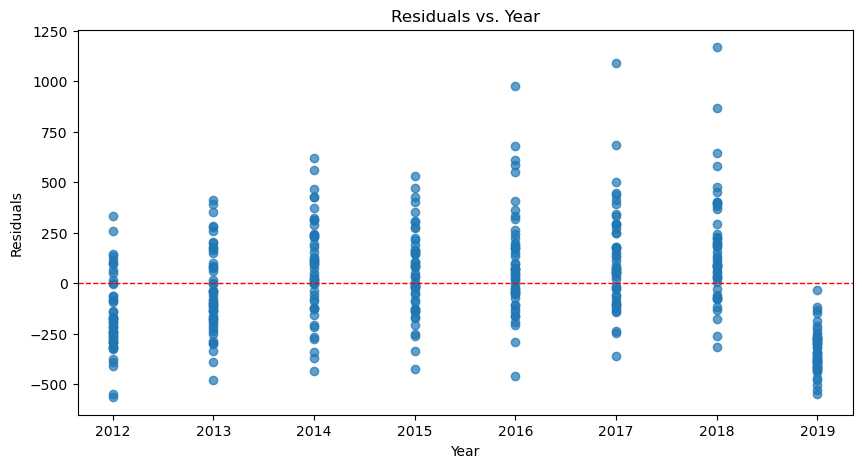

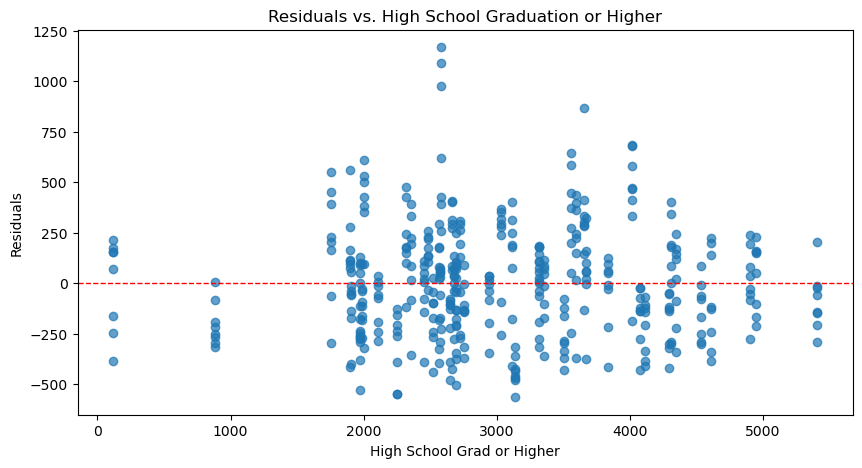

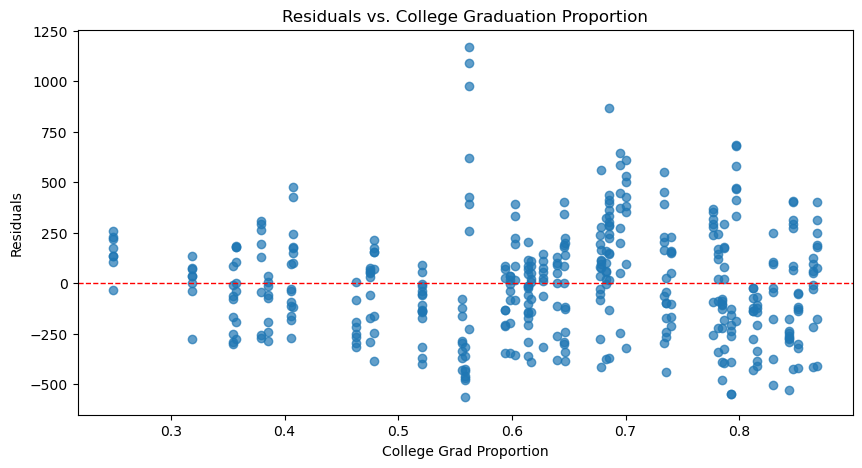

In [42]:
residuals = model.resid
# Plot residuals vs. year
plt.figure(figsize=(10, 5))
plt.scatter(data_reg['year'], residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs. Year')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.show()

# Plot residuals vs. ed_high_sch_grad_higher_25_over
plt.figure(figsize=(10, 5))
plt.scatter(data_reg['ed_high_sch_grad_higher_25_over'], residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs. High School Graduation or Higher')
plt.xlabel('High School Grad or Higher')
plt.ylabel('Residuals')
plt.show()

# Plot residuals vs. coll_grad_prop
plt.figure(figsize=(10, 5))
plt.scatter(data_reg['coll_grad_prop'], residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs. College Graduation Proportion')
plt.xlabel('College Grad Proportion')
plt.ylabel('Residuals')
plt.show()

### Critical Thinking: Ethical Implications of Using Crime Data

When working with datasets that include demographic and socioeconomic variables, there are important ethical considerations in how the data is used and interpreted. In this case, educational attainment and other demographic features could easily be misinterpreted or misused to make harmful inferences about crime and population characteristics.

**1. Harmful Use of Data**:
- **Reinforcing Biases**: If someone were to link crime rates directly to educational attainment without considering the broader context, they might reinforce harmful stereotypes. For example, suggesting that certain demographic groups or neighborhoods are more prone to crime due to lower levels of education can lead to unjust policies and increased social stigma.
- **Supporting Discriminatory Policies**: The misuse of data like this can justify discriminatory or overly harsh policing policies. By focusing on specific socioeconomic or demographic groups, authorities could disproportionately target vulnerable populations, further marginalizing them. This can perpetuate cycles of inequality, where data is used to support biased or unethical decision-making.

**2. Beneficial Use of Data**:
- **Informing Social Programs**: On the other hand, this data could be used to identify areas where additional resources are needed, such as improving access to education, healthcare, or social services. By recognizing links between educational attainment and crime, policymakers could create targeted interventions that address the root causes of crime, such as poverty and lack of opportunities.
- **Data-Driven Policy**: Properly used, this data can support equitable, evidence-based policies aimed at improving educational opportunities and community safety. Instead of focusing on punitive measures, it could guide investments in education, job training, and social support systems to reduce crime and promote social mobility.

In conclusion, how data is interpreted and used can have significant societal impacts. While it has the potential for harm, responsible and thoughtful analysis can lead to positive outcomes, such as reducing inequality and improving community well-being.